In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2010-01-01'
date_end = '2019-01-01'
normalization_window = 1000
smoothing_window = 20
forward_leap = 39
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('AA') --, 'BA', 'MMM', 'GA', 'GM', 'GE', 'AAPL', 'MSFT', 'DOW', 'AXP', 'IBM', 'JPM')
    limit 100
    ),
    stocks as (
        select 
            market_datetime
            , extract(year from market_datetime) as _year
            , extract(month from market_datetime) as month_of_year
            , extract(week from market_datetime) as week_of_year
            , symbol
            , sector
            , industry
            
            , open
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg((open - close)/open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg((high - low)/high) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            
            , volume
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_volume_fifty_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            
            , max(open) over (partition by symbol order by market_datetime rows between {normalization_window} preceding and current row) as high_open_n_days
            , min(open) over (partition by symbol order by market_datetime rows between {normalization_window} preceding and current row) as low_open_n_days
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{date_start}' and market_datetime < '{date_end}'
        ),
    summary as (
        select *
            , (average_open_hundred_days - average_open_fifty_days) / average_open_hundred_days as hundred_fifty_average_open_diff
            , (average_open_fifty_days - average_open_ten_days) / average_open_fifty_days as fifty_ten_average_open_diff
            , (high_open_hundred_days - low_open_hundred_days) / high_open_hundred_days as hundred_high_low_open_diff
            , (average_volume_hundred_days - average_volume_fifty_days) / average_volume_hundred_days as hundred_fifty_average_volume_diff
            , (average_volume_fifty_days - average_volume_ten_days) / average_volume_fifty_days as fifty_ten_average_volume_diff
            , high_open_n_days - low_open_n_days as normalization_range
            , (open - low_open_n_days) / (high_open_n_days - low_open_n_days) as normalized_open
        from stocks
        where market_datetime > '{date_start}'::date + interval '100' day
        and market_datetime < '{date_end}'::date - interval '10' day
        ),
    aggregates as (
        select *
            , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, sector) as sector_hundred_fifty_average_open_diff
            , avg(fifty_ten_average_open_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_open_diff
            , avg(hundred_high_low_open_diff) over (partition by market_datetime, sector) as sector_hundred_high_low_open_diff
            , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_volume_diff
            , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, industry) as industry_hundred_fifty_average_open_diff
            , avg(fifty_ten_average_open_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_open_diff
            , avg(hundred_high_low_open_diff) over (partition by market_datetime, industry) as industry_hundred_high_low_open_diff
            , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_volume_diff
            , avg(hundred_fifty_average_open_diff) over (partition by market_datetime) as market_hundred_fifty_average_open_diff
            , avg(fifty_ten_average_open_diff) over (partition by market_datetime) as market_fifty_ten_average_open_diff
            , avg(hundred_high_low_open_diff) over (partition by market_datetime) as market_hundred_high_low_open_diff
            , avg(fifty_ten_average_volume_diff) over (partition by market_datetime) as market_fifty_ten_average_volume_diff
            , avg(normalized_open) over (partition by symbol order by market_datetime rows between {smoothing_window} preceding and current row) as smoothed_normalized_open
        from summary
        )
    select *
        , lead(smoothed_normalized_open, {forward_leap}) over (partition by symbol order by market_datetime) as target
    from aggregates
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,_year,month_of_year,week_of_year,symbol,sector,industry,open,average_open_hundred_days,average_open_fifty_days,...,industry_hundred_fifty_average_open_diff,industry_fifty_ten_average_open_diff,industry_hundred_high_low_open_diff,industry_fifty_ten_average_volume_diff,market_hundred_fifty_average_open_diff,market_fifty_ten_average_open_diff,market_hundred_high_low_open_diff,market_fifty_ten_average_volume_diff,smoothed_normalized_open,target
0,2010-04-12 05:00:00,2010.0,4.0,15.0,AA,Basic Industries,Aluminum,43.530003,42.724191,41.377353,...,0.031524,-0.053903,0.262436,0.055953,0.031524,-0.053903,0.262436,0.055953,0.350763,0.064429
1,2010-04-13 05:00:00,2010.0,4.0,15.0,AA,Basic Industries,Aluminum,42.900003,42.726739,41.429117,...,0.030370,-0.052685,0.262436,-0.087770,0.030370,-0.052685,0.262436,-0.087770,0.327887,0.064429
2,2010-04-14 05:00:00,2010.0,4.0,15.0,AA,Basic Industries,Aluminum,43.170003,42.733071,41.503235,...,0.028779,-0.050411,0.262436,-0.119891,0.028779,-0.050411,0.262436,-0.119891,0.326798,0.063305
3,2010-04-15 05:00:00,2010.0,4.0,15.0,AA,Basic Industries,Aluminum,42.990003,42.736690,41.582059,...,0.027017,-0.047567,0.262436,-0.141142,0.027017,-0.047567,0.262436,-0.141142,0.322985,0.065731
4,2010-04-16 05:00:00,2010.0,4.0,15.0,AA,Basic Industries,Aluminum,42.660000,42.735625,41.609117,...,0.026360,-0.046362,0.262436,-0.210811,0.026360,-0.046362,0.262436,-0.210811,0.315904,0.069226


### Clean data

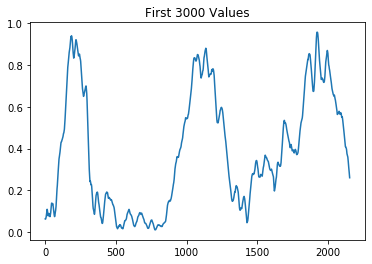

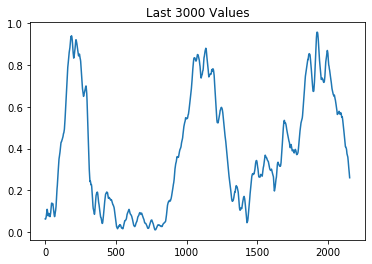

In [3]:
n = 3000
plt.title(f'First {n} Values')
plt.plot(df['target'].head(n))
plt.show()
plt.title(f'Last {n} Values')
plt.plot(df['target'].tail(n))
plt.show()

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


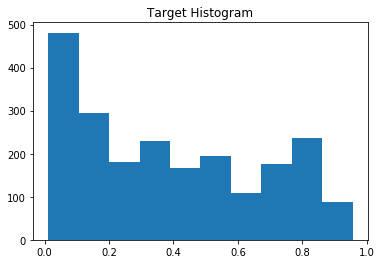

In [4]:
plt.hist(df['target'])
plt.title('Target Histogram')
plt.show()

In [5]:
df['market_datetime_month'] = df['market_datetime'].dt.month
df['market_datetime_day_of_week'] = df['market_datetime'].dt.dayofweek

df['market_datetime_int'] = df['market_datetime'].astype(int)

df = cluster_utils.encode_one_hot(df, ['symbol', 'sector', 'industry', 
                                       'market_datetime_month', 'market_datetime_day_of_week'])

In [6]:
cols_to_ignore = ['symbol', 'sector', 'industry', 'market_datetime', 'market_datetime_month', 'market_datetime_day_of_week', 'target']

for col in df.drop(cols_to_ignore, axis=1).columns:
    df = cluster_utils.normalize(df=df, column=col)

df = df.fillna(1)

In [7]:
for time_shift in range(1, 60):
    df['target' + '_' + str(time_shift)] = df['target'].shift(time_shift)

df = df.dropna()

In [8]:
temp = df.copy()

y = temp['target']

x = temp[~y.isna()].reset_index(drop=True)
y = y[~y.isna()].reset_index(drop=True)

split = .5
cutoff = int(len(x) * .75)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train_x.drop(cols_to_ignore, axis=1).head(2).T)

                                                 0         1
_year                                     0.000000  0.000000
month_of_year                             0.545455  0.545455
week_of_year                              0.500000  0.500000
open                                      0.281639  0.272860
average_open_hundred_days                 0.539319  0.535860
average_open_fifty_days                   0.412462  0.404758
average_open_ten_days                     0.343734  0.334350
high_open_hundred_days                    0.553155  0.553155
low_open_hundred_days                     0.400670  0.400670
average_daily_finish_ten_days             0.764358  0.757203
average_daily_range_ten_days              0.446162  0.404467
volume                                    0.205413  0.144053
average_volume_hundred_days               0.775315  0.771729
average_volume_fifty_days                 0.787985  0.786266
average_volume_ten_days                   0.518189  0.439634
high_open_n_days        

### Create nn

In [17]:
model = nn_utils.TorchLSTM(train_x=train_x.head(1000).drop(cols_to_ignore, axis=1), 
                           train_y=train_y.head(1000),
                           test_x=test_x.head(100).drop(cols_to_ignore, axis=1), 
                           test_y=test_y.head(100),
                           n_layers=2,
                           n_epochs=100,
                           batch_size=100,
                           hidden_shape=1000,
                           dropout=.95,
                           learning_rate=.0001,
                           device='cuda:1')

Epoch  0 Error:  174.79127502441406
Epoch  10 Error:  123.41644287109375
Epoch  20 Error:  101.66156768798828
Epoch  30 Error:  85.89949798583984
Epoch  40 Error:  72.17654418945312
Epoch  50 Error:  53.259605407714844
Epoch  60 Error:  48.01808166503906
Epoch  70 Error:  35.874549865722656
Epoch  80 Error:  30.206350326538086
Epoch  90 Error:  26.336658477783203


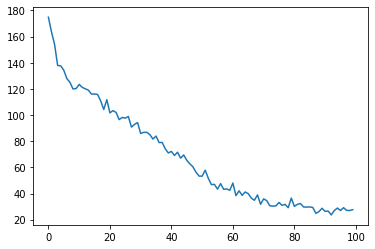

In [18]:
model.execute()

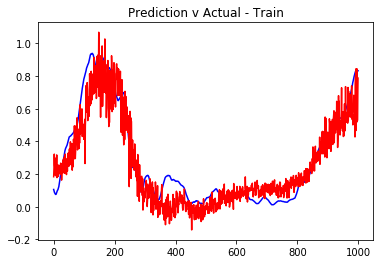

In [19]:
model.plot_prediction_train()

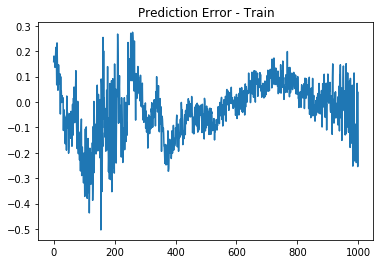

In [20]:
model.plot_prediction_train_error()

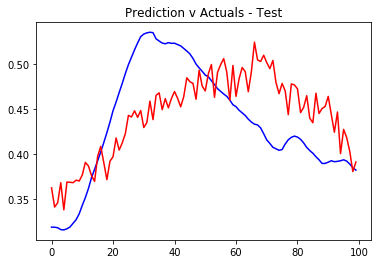

In [21]:
model.plot_prediction_test()

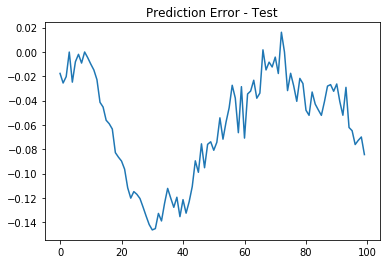

In [22]:
model.plot_prediction_test_error()

In [23]:
model.reset_network()

### Lstm on open data

In [24]:
x_temp = df['open'].values

In [25]:
sequence_length = 200

x = []
y = []

for n in range(len(x_temp) - sequence_length - 1):
    x_i = x_temp[n : n + sequence_length]
    y_i = x_temp[n + sequence_length]
    
    x.append(x_i)
    y.append(y_i)

print(len(x))

1932


In [26]:
x_arr = np.array(x)
y_arr = np.array(y)

x_var = torch.Tensor(x_arr).float()
y_var = torch.Tensor(y_arr).float()

In [32]:
model = nn_utils.TorchLSTM(train_x=pd.DataFrame(x_arr).head(1000), 
                           train_y=pd.DataFrame(y_arr).head(1000),
                           test_x=test_x.drop(cols_to_ignore, axis=1).head(500), 
                           test_y=test_y.head(500),
                           n_layers=2,
                           n_epochs=100,
                           hidden_shape=1000,
                           batch_size=1,
                           dropout=.01,
                           learning_rate=.001,
                           device='cuda:1')

Epoch  0 Error:  195.7828369140625
Epoch  10 Error:  35.298519134521484
Epoch  20 Error:  9.956605911254883
Epoch  30 Error:  8.655235290527344
Epoch  40 Error:  6.567264556884766
Epoch  50 Error:  5.41851806640625
Epoch  60 Error:  5.801276206970215
Epoch  70 Error:  4.413516044616699
Epoch  80 Error:  4.428243160247803
Epoch  90 Error:  3.624434471130371


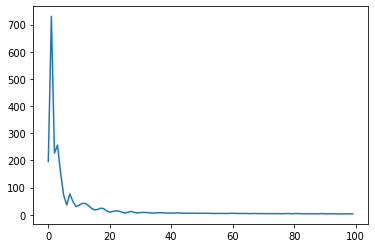

In [33]:
model.execute()

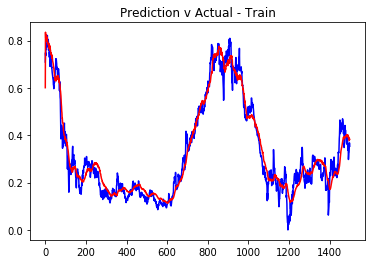

In [34]:
model.plot_prediction_train()

RuntimeError: shape '[500, 1, 200]' is invalid for input of size 58500

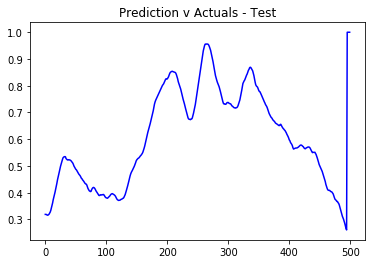

In [36]:
model.plot_prediction_test()

In [35]:
model.reset_network()